In [1]:
# ==============================
# Question 1: Train a CartPole Agent
# ==============================

In [8]:
# Gym compatibility helpers
def gym_reset(env):
    try:
        obs, _ = env.reset()  # New Gym (>=0.26)
    except:
        obs = env.reset()     # Old Gym
    return obs

def gym_step(env, action):
    try:
        obs, reward, terminated, truncated, _ = env.step(action)  # New Gym
        done = terminated or truncated
    except:
        obs, reward, done, _ = env.step(action)  # Old Gym
    return obs, reward, done

In [9]:
# install the required libraries
!pip install gym==0.26.2 torch matplotlib

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Set environment
env = gym.make('CartPole-v1')
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

In [12]:
# Simple Policy Network
class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

policy = PolicyNet()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
gamma = 0.99

def get_action(state):
    state = np.array(state, dtype=np.float32)  # Ensure state is a numpy array
    state = torch.FloatTensor(state).unsqueeze(0) # Convert to tensor and add batch dimension
    probs = policy(state)
    action = torch.multinomial(probs, 1).item()
    return action, torch.log(probs[0][action]) # Adjust indexing for batch dimension

def compute_returns(rewards, gamma):
    R, returns = 0, []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    return (returns - returns.mean()) / (returns.std() + 1e-9)

In [17]:
# Training loop
episodes = 1000
reward_history = []

for episode in range(episodes):
    state = gym_reset(env)
# Extract the observation from the tuple
    log_probs, rewards = [], []
    done = False

    while not done:
        action, log_prob = get_action(state)
        next_state, reward, done = gym_step(env, action)
        log_probs.append(log_prob)
        rewards.append(reward)
        state = next_state

    returns = compute_returns(rewards, gamma)

    loss = -torch.sum(torch.stack(log_probs) * returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_reward = sum(rewards)
    reward_history.append(total_reward)

    if episode % 50 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Total Reward: 33.0
Episode 50, Total Reward: 252.0
Episode 100, Total Reward: 77.0
Episode 150, Total Reward: 159.0
Episode 200, Total Reward: 500.0
Episode 250, Total Reward: 272.0
Episode 300, Total Reward: 47.0
Episode 350, Total Reward: 35.0
Episode 400, Total Reward: 500.0
Episode 450, Total Reward: 155.0
Episode 500, Total Reward: 125.0
Episode 550, Total Reward: 251.0
Episode 600, Total Reward: 315.0
Episode 650, Total Reward: 220.0
Episode 700, Total Reward: 500.0
Episode 750, Total Reward: 500.0
Episode 800, Total Reward: 500.0
Episode 850, Total Reward: 500.0
Episode 900, Total Reward: 9.0
Episode 950, Total Reward: 9.0


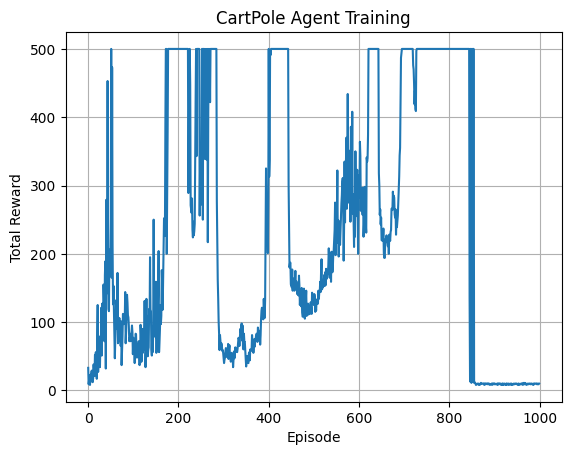

In [18]:
# Plotting
plt.plot(reward_history)
plt.title("CartPole Agent Training")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

In [19]:
# ==============================
# Question 2: Mountain Car with Q-Learning
# ==============================

In [20]:
# Install gym
!pip install gym==0.26.2 matplotlib --quiet

import numpy as np
import gym
import matplotlib.pyplot as plt

In [21]:
# Create the environment
env = gym.make("MountainCar-v0")

In [22]:
# Q-table settings
state_bins = [20, 20]  # number of bins for position and velocity
action_size = env.action_space.n
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))

In [23]:
# Create Q-table
q_table = np.random.uniform(low=-1, high=1, size=(state_bins[0], state_bins[1], action_size))

In [24]:
# Helper: safe env.reset()
def gym_reset(env):
    result = env.reset()
    if isinstance(result, tuple):
        return result[0]
    return result

# Helper: safe env.step()
def gym_step(env, action):
    result = env.step(action)
    if len(result) == 5:
        obs, reward, terminated, truncated, _ = result
        done = terminated or truncated
    else:
        obs, reward, done, _ = result
    return obs, reward, done

In [25]:
# Discretize continuous states into bins
def discretize_state(state):
    ratios = []
    for i in range(len(state)):
        min_val, max_val = state_bounds[i]
        ratio = (state[i] - min_val) / (max_val - min_val)
        ratio = np.clip(ratio, 0, 1)
        ratios.append(int(ratio * (state_bins[i] - 1)))
    return tuple(ratios)

In [26]:
# Hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.995
episodes = 5000
reward_list = []

# Training loop
for ep in range(episodes):
    obs = gym_reset(env)
    state = discretize_state(np.array(obs))
    done = False
    total_reward = 0

    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        next_obs, reward, done = gym_step(env, action)
        next_state = discretize_state(np.array(next_obs))

        best_next_q = np.max(q_table[next_state])
        q_table[state][action] += alpha * (reward + gamma * best_next_q - q_table[state][action])

        state = next_state
        total_reward += reward

    reward_list.append(total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if ep % 500 == 0:
        print(f"Episode {ep}: Total reward = {total_reward}, Epsilon = {epsilon:.3f}")

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0: Total reward = -200.0, Epsilon = 0.995
Episode 500: Total reward = -200.0, Epsilon = 0.081
Episode 1000: Total reward = -200.0, Epsilon = 0.010
Episode 1500: Total reward = -165.0, Epsilon = 0.010
Episode 2000: Total reward = -200.0, Epsilon = 0.010
Episode 2500: Total reward = -192.0, Epsilon = 0.010
Episode 3000: Total reward = -155.0, Epsilon = 0.010
Episode 3500: Total reward = -200.0, Epsilon = 0.010
Episode 4000: Total reward = -200.0, Epsilon = 0.010
Episode 4500: Total reward = -146.0, Epsilon = 0.010


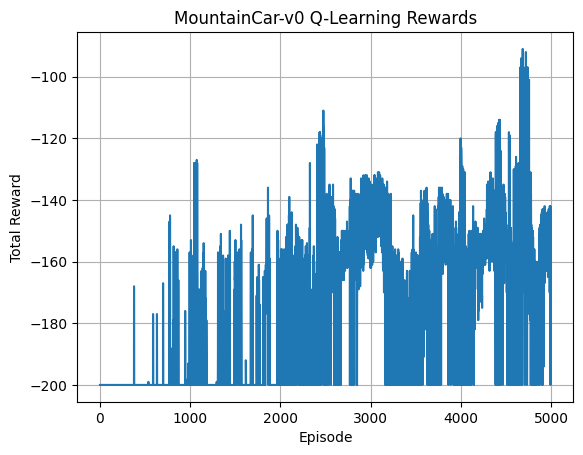

In [27]:
# Plotting
plt.plot(reward_list)
plt.title("MountainCar-v0 Q-Learning Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

In [28]:
# ==========================
        #COMPLETED#
# ==========================